# Prac Deep Learning Sys (COMS 6998-015)
## Homework 3
### Nathan Coulibaly, nmc2169

## Problem 1

1. Evaluation of pretrained MobilenetV1 SSD (mobilenet-v1-ssd-mp-0_675.pth) with Pascal VOC 2007 Dataset:

    **Average Precision Per Class:**

    - **aeroplane**: 0.6843
    - **bicycle**: 0.7911
    - **bird**: 0.6172
    - **boat**: 0.5613
    - **bottle**: 0.3483
    - **bus**: 0.7684
    - **car**: 0.7281
    - **cat**: 0.8369
    - **chair**: 0.5169
    - **cow**: 0.6239
    - **diningtable**: 0.7063
    - **dog**: 0.7873
    - **horse**: 0.8195
    - **motorbike**: 0.7924
    - **person**: 0.7023
    - **pottedplant**: 0.3985
    - **sheep**: 0.6067
    - **sofa**: 0.7572
    - **train**: 0.8262
    - **tvmonitor**: 0.6465

    **Average Precision Across All Classes**: **0.6760**
    

Pretrained mobilenet-v1-ssd-mp-0_675 model with 3 classes (BACKGROUND, Airplane, Helicopter)

**Average Precision Per-class:**
- **Airplane**: 0.007641559442716817
- **Helicopter**: 0.005506622493994895

**Average Precision Across All Classes:** 0.006574090968355857

After fine-tuning for 10 epochs on open_images airplane and helicopter dataset, Validation Loss: 1.9261, Validation Regression Loss 0.6156, Validation Classification Loss: 1.3105

**Average Precision Per-class:**
 - **Airplane:** 0.7871694636324705
 - **Helicopter:** 0.8729167315760018

**Average Precision Across All Classes:** 0.8300430976042361

In [1]:
import torch
import torch.onnx
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd  # Adjust the import if necessary

model_path = "models/mb1-ssd-Epoch-9-Loss-1.9260564812010141.pth"
model = create_mobilenetv1_ssd(num_classes=3) 
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Define a dummy input tensor
dummy_input = torch.randn(1, 3, 300, 300)

with torch.no_grad():
    pytorch_output = model(dummy_input)

print(f"PyTorch output: {pytorch_output}")

# Export the model to ONNX format
onnx_path = "models/finetuned-mb1-ssd.onnx" 
torch.onnx.export(
    model,                     # Model to be exported
    dummy_input,               # Dummy input tensor
    onnx_path,                 # Output file path
    export_params=True,        # Store the trained parameter weights inside the model file
    opset_version=11,          # ONNX opset version to export the model
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input'],     # Input name (optional)
    output_names=['output']    # Output name (optional)
)

print(f"Model exported to {onnx_path}")

/tmp/ipykernel_31747/425630200.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


PyTorch output: (tensor([[[ 2.7067, -0.0481, -2.5708],
         [ 3.0105, -0.3939, -2.5286],
         [ 2.6784, -0.0125, -2.6966],
         ...,
         [ 2.1973, -0.0763, -2.1296],
         [ 2.4602,  0.1056, -2.5215],
         [ 2.1238, -0.1471, -2.0171]]]), tensor([[[ 1.2836,  1.5608, -4.3793, -5.8038],
         [ 0.1748,  0.3736, -0.5482, -1.3703],
         [ 1.3982,  0.6396, -5.4957, -4.8404],
         ...,
         [ 0.0265,  0.1725,  1.6046, -0.3113],
         [ 0.1325,  0.2001, -0.3001,  2.1285],
         [-0.0083,  0.1599,  2.5981, -0.2166]]]))
Model exported to models/finetuned-mb1-ssd.onnx


In [2]:
import onnx

# Load the ONNX model
onnx_model_path = "models/finetuned-mb1-ssd.onnx"
model = onnx.load(onnx_model_path)

# Verify the model’s structure
try:
    onnx.checker.check_model(model)
    print("The ONNX model is valid.")
except onnx.checker.ValidationError as e:
    print(f"The ONNX model is invalid: {e}")

The ONNX model is valid.


In [3]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "models/finetuned-mb1-ssd.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Define a dummy input tensor
dummy_input = np.random.randn(1, 3, 300, 300).astype(np.float32)

# Run the ONNX model with the dummy input tensor
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

# Run the ONNX inference
outputs = ort_session.run([output_name], {input_name: dummy_input})

print("Model Output:", outputs[0])

Model Output: [[[ 2.628398   -0.09165876 -2.416489  ]
  [ 3.0297675  -0.4312416  -2.5319319 ]
  [ 2.660162    0.05083796 -2.7098558 ]
  ...
  [ 2.2011666  -0.07641503 -2.132676  ]
  [ 2.469308    0.10345399 -2.5300725 ]
  [ 2.128943   -0.14993942 -2.0211074 ]]]


In [4]:
pytorch_output_np = pytorch_output[0].detach().cpu().numpy()  # Adjust indexing if model returns multiple outputs
onnx_output = outputs[0]

if np.allclose(pytorch_output_np, onnx_output, rtol=1e-5, atol=1e-5):
    print("The outputs from PyTorch and ONNX Runtime match within the specified tolerance.")
else:
    print("The outputs from PyTorch and ONNX Runtime do not match.")

The outputs from PyTorch and ONNX Runtime do not match.


- rtol=1e-5: Relative tolerance of 1e-5 means that the difference between PyTorch and ONNX values can be up to 0.001% of the PyTorch value and still be considered a match.
- atol=1e-5: Absolute tolerance of 1e-5 means that very small values (close to zero) can differ by up to 1e-5.


In [5]:
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as transforms

In [6]:
# Define paths to the images and model
image_paths = ["data/test_images/airplane.jpg", "data/test_images/helicopter.jpg"]  
onnx_model_path = "models/finetuned-mb1-ssd.onnx"

# Create an inference session with ONNX Runtime
session = ort.InferenceSession(onnx_model_path)

# Preprocessing function
def preprocess_image(image_path, input_size=(300, 300)):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Define preprocessing steps (resize, normalize, etc.)
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean/std based on model needs
    ])
    
    # Apply transformations
    image_tensor = preprocess(image)
    
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)  # Shape: (1, 3, 300, 300)
    
    return image_tensor.numpy()  # Convert to numpy for ONNX Runtime

In [7]:
for image_path in image_paths:
    # Preprocess the image
    input_data = preprocess_image(image_path)
    
    # Get input and output names for ONNX Runtime
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    # Run inference
    outputs = session.run([output_name], {input_name: input_data})
    
    # Print the output (for real applications, interpret this output properly)
    print(f"Output for {image_path}: {outputs[0]}")

Output for data/test_images/airplane.jpg: [[[ 4.138382   -0.9878388  -3.0577788 ]
  [ 4.22545    -1.4909672  -2.6169086 ]
  [ 3.8684378  -1.0116055  -2.864805  ]
  ...
  [ 0.5566062   1.7188514  -2.3376985 ]
  [-1.7088915   3.212818   -1.5116981 ]
  [ 2.3896177   0.58438176 -2.919279  ]]]
Output for data/test_images/helicopter.jpg: [[[ 4.265738   -0.82885605 -3.3536644 ]
  [ 4.3293333  -0.9208403  -3.3959553 ]
  [ 4.0182996  -0.63204706 -3.3168209 ]
  ...
  [ 0.50133926 -2.3493757   1.7498918 ]
  [-0.7328597  -1.7276728   2.302973  ]
  [ 1.6628044  -2.7264628   1.0709631 ]]]


In [33]:
labels = ["airplane", "helicopter", "BACKGROUND"]

In [34]:
def preprocess_image(image_path, input_size=(300, 300)):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust mean/std as needed
    ])
    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor.numpy(), image

In [35]:
def parse_output(outputs, threshold=0.5):
    # Extract the single tensor from outputs
    detections = outputs[0]
    
    # Initialize lists for results
    result_boxes = []  # If there are no bounding boxes, this remains empty
    result_labels = []
    result_scores = []
    
    # Iterate over the detections
    for detection in detections[0]:  # Iterate over 3000 detections
        class_confidence, class_id, _ = detection  # Hypothetical structure
        if class_confidence > threshold:
            result_labels.append(labels[int(class_id)])  # Assuming class_id corresponds to a label index
            result_scores.append(class_confidence)
            # Add a dummy box if your SSD model is supposed to provide bounding boxes
            result_boxes.append([0, 0, 1, 1])  # Dummy bounding box (replace with actual if available)

    return result_boxes, result_labels, result_scores

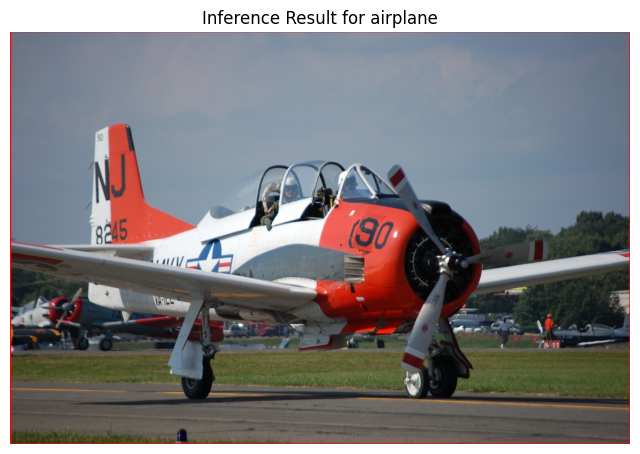

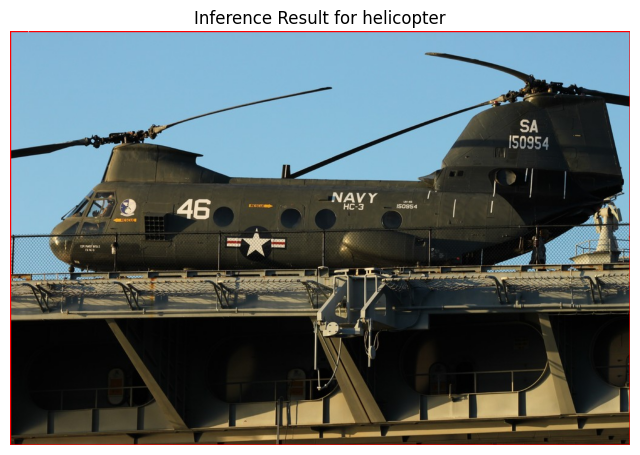

In [36]:
import matplotlib.pyplot as plt

for image_path in image_paths:
    # Preprocess the image
    input_data, original_image = preprocess_image(image_path)

    # Run inference
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    outputs = session.run([output_name], {input_name: input_data})

    # Parse the output
    result_boxes, result_labels, result_scores = parse_output(outputs)

    # Annotate the image
    draw = ImageDraw.Draw(original_image)
    font = ImageFont.load_default()
    for box, label, score in zip(result_boxes, result_labels, result_scores):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin * original_image.width), int(ymin * original_image.height), int(xmax * original_image.width), int(ymax * original_image.height)
        
        # Draw bounding box
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red", width=2)
        
        # Draw label and score
        text = f"{label}: {score:.2f}"
        text_size = font.getbbox(text)  # Get the bounding box of the text
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]

        # Draw the background rectangle for the label
        draw.rectangle([(xmin, ymin - text_height), (xmin + text_width, ymin)], fill="red")
        draw.text((xmin, ymin - text_height), text, fill="white", font=font)

    # Display the annotated image
    plt.figure(figsize=(8, 8))
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Inference Result for {label}")
    plt.show()

## Problem 2

1. Fine-tuning with Daimler Ped dataset from the Visual Domain Decathlon

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = 'data/daimlerpedcls'
image_datasets = {
    'train': ImageFolder(data_dir + '/train', data_transforms['train']),
    'val': ImageFolder(data_dir + '/val', data_transforms['val']),
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=64, shuffle=False, num_workers=4),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)  # 2 classes for the Daimler Ped dataset
model_ft = model_ft.to(device)

/home/nathancoulibaly/llmdlsysperf/pytorch-ssd/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nathancoulibaly/llmdlsysperf/pytorch-ssd/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

scheduler = MultiStepLR(optimizer_ft, milestones=[25, 50, 75], gamma=0.1)

**Output pasted from google colab running on A100**

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer_ft.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print('Training complete')

Epoch 0/99
----------
train Loss: 0.0953 Acc: 0.9618
val Loss: 0.0175 Acc: 0.9942
Epoch 1/99
----------
train Loss: 0.0122 Acc: 0.9964
val Loss: 0.0078 Acc: 0.9973
Epoch 2/99
----------
train Loss: 0.0057 Acc: 0.9985
val Loss: 0.0051 Acc: 0.9974
Epoch 3/99
----------
train Loss: 0.0038 Acc: 0.9989
val Loss: 0.0033 Acc: 0.9991
Epoch 4/99
----------
train Loss: 0.0021 Acc: 0.9994
val Loss: 0.0037 Acc: 0.9988
Epoch 5/99
----------
train Loss: 0.0018 Acc: 0.9996
val Loss: 0.0034 Acc: 0.9985
Epoch 6/99
----------
train Loss: 0.0020 Acc: 0.9995
val Loss: 0.0024 Acc: 0.9993
Epoch 7/99
----------
train Loss: 0.0011 Acc: 0.9998
val Loss: 0.0021 Acc: 0.9988
Epoch 8/99
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0017 Acc: 0.9995
Epoch 9/99
----------
train Loss: 0.0006 Acc: 1.0000
val Loss: 0.0017 Acc: 0.9991
Epoch 10/99
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0014 Acc: 0.9995
Epoch 11/99
----------
train Loss: 0.0005 Acc: 0.9999
val Loss: 0.0014 Acc: 0.9995
Epoch 12/99
--

In [ ]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=150):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Training complete')
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, best_acc